# Deep Reinforcement learning

Author : Nicholas Setijabudiharsa

TSE - Econometrics and Statistics : Data science for social science

2022

### Motivation

In order to better understand the idea of reinforcement learning, lets take an example of a game of chess. Theoritically speaking, one can create an brute force algorithm that analyze all possible states of the game and takes into account all the possible states that can come after the current state, and take the action that give the most probability of winning at the end. However, this method is very inefficient. In 2021, [John Tromp](https://github.com/tromp/ChessPositionRanking) did an analysis and found that there are about $4.8 x 10^{44}$ possible combinations of legal chess positions in chess. For perspective, here is the full form of that number

$$480000000000000000000000000000000000000000000$$

So for sure, this process is very inefficient. This is where Reinforcement learning comes in handy.

In this notebook, we will first discuss the [definitions and the framework](https://www.davidsilver.uk/wp-content/uploads/2020/03/intro_RL.pdf) often used in most RL courses you see online, then, we will explore a little bit about what is a [Markov Decision Process](https://www.davidsilver.uk/wp-content/uploads/2020/03/MDP.pdf) (MDP), then, we will talk about how we can [approximate our value function](https://www.davidsilver.uk/wp-content/uploads/2020/03/FA.pdf) using Q learning and DQN, additionally, we will explore as well some methods from the [rainbow paper](https://arxiv.org/pdf/1710.02298.pdf) and [policy gradient](https://www.davidsilver.uk/wp-content/uploads/2020/03/pg.pdf)

## Case study

In this notebook we will explore different reinforcement learning method and applying it to the [CartPole](https://www.gymlibrary.dev/environments/classic_control/cart_pole/) environment. Then we will look into applying our algorithm to one of Minatar instance of the game [Space Invaders](https://github.com/kenjyoung/MinAtar#space-invaders)

We will be using the gym environment library. By running the code below, you can see an example of episodes with taking random action

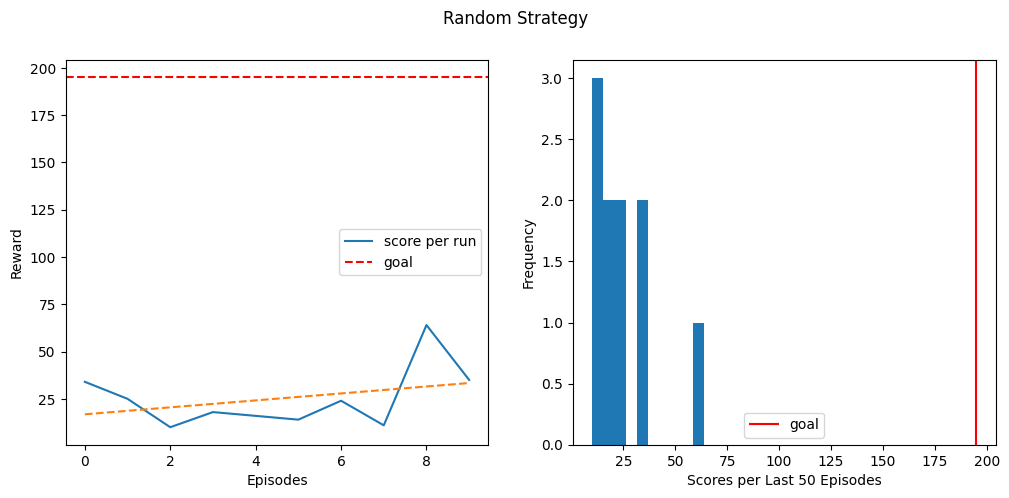

In [1]:
from scripts.play_random_action import play_random_action
play_random_action('CartPole-v1', 10)

## Definitions and  Framework of Reinforcement Learning

We firstly define :
- **State space** $S$ to be the space of all the parameters of our environment that can help us to understand our environment better
- **Action space** $A$ to be the space of all possible action we can take in a given environment. 

the classic example that we often see to better understand this notion is for example the atari game Breakout. Our agent (the paddle) will need the state space to be able to let it understand the environment best, therefore $S$ will be the tuple of all the coordinates of bricks that are still not yet hit by the ball, the coordinate of the ball, and the coordinate of the paddle. and the set $A$ is simply a set of 2 actions whether the paddle to go left or right.


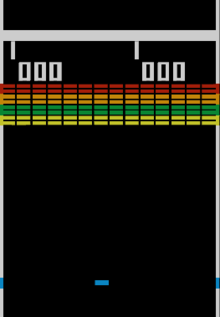



We can now define another common terminology which is the **policy** $\pi$ in the topic. A policy $\pi$ is a mapping from the state space to an action space that simply represents the agent to take an action $a$ from a state $s$ i.e.

$$
\begin{align*}
  \pi \colon S &\to A \\
  s &\mapsto a
\end{align*}
$$
_Remark : the policy function can be deterministic $\pi(s) = a$ or stochastic policy where $\pi(a|s) = \mathbb{P}[A=a | S=s]$_

Let us now define the notion of **value function** which is a function that represents a measure of how good of a state / action is for our agent and is represented by the expected of future rewards

$$
v_{\pi(s)} = \mathbb{E}_\pi[R_{t+1} + R_{t+2} + \dots | S_t = s]
$$

For our application, it is suffices to assume an agent is defined by their policy function $\pi$ and their value function $v$.

Reinforcement learning is the process optimizing an agent's action $a \in A$ with $A$ to be defined as the action space of our environment, and a given state $s\in S$ with $S$ to be the state space of our environment, and by optimizing it's policy $\pi(s, a)$ where $\pi(s, a) = Pr(a=a | s=s)$ the stochastic version of the policy, such that it maximizes the total rewards of the agent. In other words, reinforcement learning is a **maximization problem** where we **optimize** our agent's _policy_ to **maximize** future rewards.

Taking the chess as our example, the state space will contains all the possible legal positions of each pieces in the board. and the action space can be defined as a pair of $(p, l_target)$ where $p \in [King, Queen, Horse, etc]$ is the piece that is to be moved and $l_{target} \in \mathbb{R}^2$  is the location that the piece is being moved to.

An environment where we get an information about the reward after every action an agent take, is called **Dense** rewards, for example, minesweeper, on the other hand, environment such as playing a simple game of chess where we only receive rewards at the end of the game (whether we win or loses), is called **Sparse** rewards, naturally, the denser the rewards, the more efficient our data will be and therefore faster our learning will be.

## Markov Decision Process (MDP)

A state $S_t$ is Markov if and only if the distribution of future state can be fully observed simply by looking at the last state. In other words

$$
\mathbb{P}[S_{t+1}|S_1, \dots S_t] =\mathbb{P}[S_{t+1}| S_t]
$$

A markov process can then be defined by the tuple $(\mathcal{S}, \mathcal{P})$ where $\mathcal{S}$ is a finite set of states, and $\mathcal{P}$ to be the state transition probability matrix such that each element represents $P_{ss'} = \mathbb{P}[S_{t+1} = s' | S_t = s] $

Thus, we can now understand that an Markov Decision Process (MDP) is an extension of a markov process with 3 additional parameters:
- **$\mathcal{A}$** to be the finite set of actions
- **$\mathcal{R}$** to be the reward function defined on the action level s.t.
$$
R^a_s = \mathbb{E}[R_{t+1}|S_t=s, A_t = a]
$$
- **$\gamma$** to be the discount factor of future rewards defined on the $[0, 1] \subset \mathbb{R}$

*Remark: Another consequences of this, is that we dont take the future states with certainty but instead given a current state $s_t$, we assume that $s_{t+1}$ adopts a certain probability distribution. For example, any games that includes rolling a dice contains an element of randomness that originates from the random variable of the dice number.*

It is important now to define what is a **state-value function** and the **action-value** function. While both of them are quite similar in a sense that they are both defined on a given MDP, and both represents some sort of value, there is indeed a slight difference. 
- The **State value** function of and MDP is the expected return from state s when following policy $\pi$ at time $t$

$$
v_\pi(s) = \mathbb{E}_\pi[\overbrace{ \sum_{k=0}^\infty \gamma^k R_{t+k+1}}^\text{total future discounted rewards := $G_t$} | S_t = s]
$$


- where **Action value** function of and MDP is the expected return from state s when following policy $\pi$ **and taking action a** at time $t$.

$$
q_\pi(s, a) = \mathbb{E}_\pi[G_t| S_t = s, A_t = a]
$$

It is worth noting that the relationship between $v_\pi(s)$ and $q_\pi(s, a)$ are the following:

$$
v_\pi(s) = \sum_{a \in A} \pi(a|s) \times q_\pi(s, a)
$$



### Existence theorem

A theorem related to the MDP states that for any MDP:
- $\exists \pi^* s.t. v_{\pi^*}(s) \geq v_{\pi}(s) \forall s \in \mathcal{S}, \forall \pi $ where:
    - $v_{\pi^*}(s) = v^*(s)$
    - $q_{\pi^*}(s, a) = q^*(s, a)$

*Remark: Assuming we observe all of our environment, the $\pi^*$ can be found by a greedy algorithm that iteratively modifies $\pi_{t+1}(s) = \text{argmax}_{a\in\mathcal{A}} q_\pi(s, a)$ until there is no more improvements can be made or a stopping criterion has been attained*


## Estimation of state value function

We can estimate our state value function $v_\pi(s)$ using different methods, in particular we will discuss _Monte-Carlo_(MC) learning, and _Temporal-difference_(TD).



#### Monte-Carlo methods

Ever heard of **"learning by doing"** ? This is the simple idea behind every monte carlo method. With this method, we estimate the state value function as the average returns we get when visiting a particular state. 

In other words, it is an estimation method of our value function by updating the value function $V(s)$ with the empirical mean of the value of the states after each iteration. 

In a more concrete manner, the algorithm works by the following:

1. Initialize $\pi$, $V$, and $R$ nested array of returns history for every possible states $s$
2. Repeat:
    - Initilize G to be 0
    - Generate an episode following $\pi$
    - For every state $s$ in $S$ in the episode:
        - We set G = $\gamma$ G + R with $\gamma$ to be the discoutn factor of previous states
        - add G to the R(s)
        - update V(s) as the average of the R(s)

i.e. note that by law of large numbers, we have that $V(s) \rightarrow v_\pi(s)$



One thing that could assist us is to also be able to calculate the mean incrementally, we also recall that :

$$
\begin{aligned}
\mu_k &= \frac{1}{k} \sum_{j=1}^k x_j \\
&= \frac{1}{k} (x_k + \sum_{j=1}^{k-1} x_j) \\
&= \frac{1}{k} (x_k + (k-1) \mu_{k-1})\\
&= \mu_{k-1} + \frac{1}{k} (x_k - \mu_{k-1}) )\\
\end{aligned}
$$

Thus, this allow us to update the $V(s)$ incrementally by setting $V(s)$ at time t by $V(s) + \frac{1}{n_s} (G^s_t - V(s))$, normally we consider an $\alpha$ to be a learning rate and the new update formulation would be:

$$
V(s_t) = V(s_t) + \alpha (G^s_t - V(s_t))
$$

where if $\alpha=\frac{1}{n_s}$ is equivalent to calculating the average of the values of the state.

##### Some code implementation of Monte-Carlo
```
def MC(env, discount_factor=1.0, iterations = 100):
    vfn = {}
    states_count = {}
    returns = {}
    for i in range(iterations):
        episode = play_random_policy_episode(env)
        G = 0
        viewed_state = []
        for t, (_state, action, reward) in enumerate(episode):
            state = convert_state(_state)
            G = G*discount_factor + reward
            if not state in viewed_state:
                viewed_state += [state]
                returns[state] = G
                states_count[state] = 1
            else:
                returns[state] += G
                states_count[state] += 1
            vfn[state] = returns[state] / states_count[state]
    return vfn
```

_Remark: In the CartPole environment, The [observation space](https://www.gymlibrary.dev/environments/classic_control/cart_pole/#observation-space) is a 4 dimensional which indicates the cart position, velocity, pole angle, and pole angular velocity._

For simplicity we will look at only 1 dimension of the observation space which is the cart position, since visualizing in 4 dimension will make it very difficult to interpret the result.

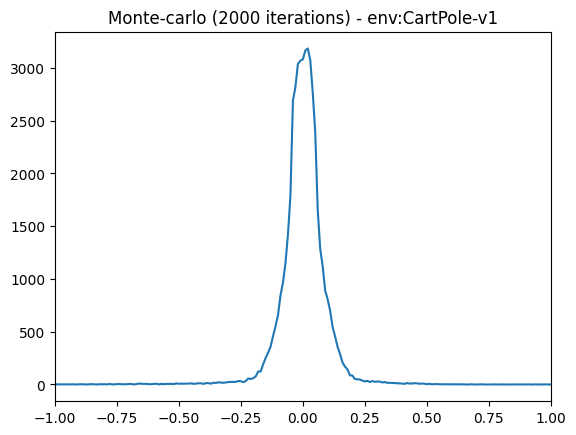

In [1]:
from scripts.state_value_function import plot_value_function_mc

DISCOUNT_FACTOR=0.1

plot_value_function_mc(discount_factor=DISCOUNT_FACTOR)

#### Temporal Differences

Temporal Differences uses the estimated return of the next steps in constrast with the MC methods that uses the discounted rewards of the state it self.

Tn other words at every iteration $V(S_t) = V(S_t) + \alpha (R_{t+1} + \gamma V(S_{t+1}) - V(S_t))$ with the following elements:
- $\gamma$ to be the discount factor of future values
- $R_{t+1}$ to be the rewards received at t+1 following the policy $\pi$
- $V(S_{t+1})$ to be the state value of being in the next state at time t+1

**Remark: $R_{t+1} + \gamma V(S_{t+1})$ is often called temporal difference target and it represents the estimated return consisting of future rewards and the value of being in the future state**

This method is the simplest form of TD usually noted as TD(0). The idea is to basically look into the immediate next step, at after being in the state S. 

To take this method further, we can look into the next n-step often also called TD($\lambda$). In other words when we consider n=1, 2, $\infty$:


$$
\begin{aligned}
n=1 & \rightarrow G_t^1 = R_{t+1} + \gamma V(S_{t+1})\\
n=2 & \rightarrow G_t^2 = R_{t+1} + \gamma R_{t+2} + \gamma^2 V(S_{t+2})\\
\vdots \\
n=\infty & \rightarrow G_t^\infty = R_{t+1} + \gamma R_{t+2} + ... + \gamma^{T-1} R_T \implies MC
\end{aligned}
$$

##### Some code implementation of Temporal Differences
```
def TD(env, discount_factor=1.0, iterations = 100, alpha=0.01):
    vfn = collections.defaultdict(float)
    for i in range(iterations):
        episode = play_random_policy_episode(env)
        for t, (_state, action, reward) in enumerate(episode[1:]):
            state = convert_state(_state)
            old_state = convert_state(episode[t-1][0])
            if old_state not in vfn.keys():
                vfn[old_state] = 0
            if state not in vfn.keys():
                vfn[state] = 0
            vfn[old_state] += alpha * (reward + discount_factor * reward - vfn[state])
    return vfn    
```

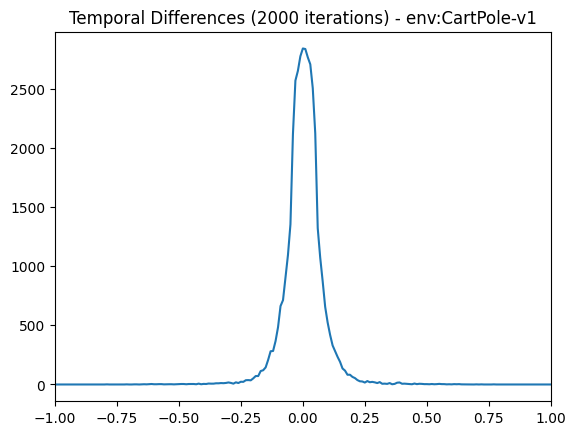

In [2]:
from scripts.state_value_function import plot_value_function_td

DISCOUNT_FACTOR=0.1
ALPHA = 0.9

plot_value_function_td(discount_factor=DISCOUNT_FACTOR, alpha=ALPHA)


## Estimation of action value function with Q-value

Given our framework of reinforcement learning defined above, we can now discuss about the framework of *Q learning*. Q learning is a reinforcement learning policy that is based on the process of assigning a certain value Q for every state and action pair and this process boils down to generate a function Q such that with the goal of estimating an **action-value function** such that:

$$
\begin{align*}
  Q \colon (S \times A) &\to \mathbb{R} \\
  (s, a) &\mapsto q.
\end{align*}
$$

Where if $s \in S$ and $a \in A$, we have $Q(s, a)$ represents the value of the action $a$ when taken at a state $s$ and the optimal $Q^*(s, a)$ is one that represents $max_\pi\mathbb{E}[\sum_{t'=t}^T\gamma^{t'-t}r_{t'} | s_t=s, a_t=a, \pi]$ with T being the final state of our environment.

The algorithm updates the Q function using the **Bellman equation** which is an iterative method that updayes a new function using the weighted average of the current value and the new information, assuming we wil always take the best action.

$$
Q^{new}(s_t, a_t) =  (1-\underbrace{\alpha}_\text{learning rate})\overbrace{Q(s_t, a_t)}^\text{Current value}  + \underbrace{\alpha}_\text{learning rate} \times ( \overbrace{r_t}^\text{current reward} + \underbrace{\gamma}_\text{discount factor} \times \overbrace{max_a Q(s_{t+1}, a)}^\text{future value while action maximized} )
$$

The above equation can also be simplified using to be the following iterative method:

$$
\begin{aligned}
Q^{new}(s_t, a_t) &= Q(s_t, a_t) - \alpha Q(s_t, a_t) + \alpha  r_t + \alpha \gamma max_a Q(s_{t+1}, a)\\
&= Q(s_t, a_t) + \alpha (r + \gamma max_a Q(s_{t+1}, a) - Q(s_t, a_t))
\end{aligned}
$$

**Remark:** Just like before, we can denote the $r + \gamma max_a Q(s_{t+1}, a)$ to be the **target**


Thus in a nutshell, the algorithm works as the following:

```
Q function is initialized by the programmer to an arbitrary value
For every episode t:
    Initialize S
    For every step of episode:
        Choosing an A from S using policy derived from Q
        Take action A
        Observe a reward R
        Update Q based on the Bellman equation
        S = S'
    Until S is the terminal
If stopping cretiria is met (number of episodes reached t or Q function is not changed) then stop
```

note that the Q function in ourcase for a discrete state and action space, it can very be a matrix with a bijection from each row to the state space and each column to the action space.



### $\epsilon$-greedy policy

Now that we will take into account our action space, it will be useful to first mentioned a more defined policy instead of just taking random sample from the action space.

A greedy policy improvement over $Q(s, a)$ is $$\pi'(s)=\text{argmax}_{a \in \mathcal{A}} Q(s, a)$$

We define a $\epsilon$-greeedy policy is the simplest idea to ensure a we keep exploring even when we are happy enough with our exploitation such that every action will be played with a non-zero probability.

Practically speaking, we can define our policy as an array of non zeros with the size of our action space. Then using our action state value function, we can look for the index of the policy array that represents the best action.


Like before, we will try to visualize the state and action value mapping but due to dimensionality issues we will just visualize based on the cart position. Luckily the action space of the environment is just 2 Discrete values to either go left or right, from there we could plot the value of going left based on a given position, and similarly to go right. However it is hard to interpret because it the position of the cart alone doesnt give us the full picture of the states (e.g. could be that position of the cart is on the left of the screen but the velocity is going to the right)

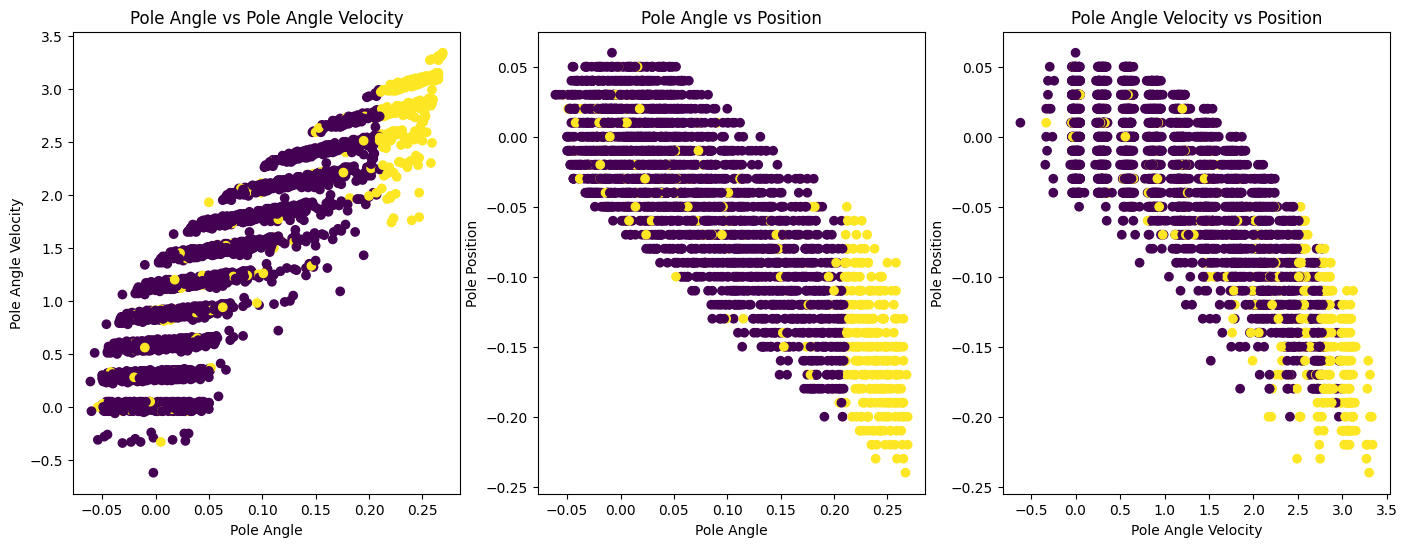

In [4]:
from scripts.state_action_value_function import plot_q

plot_q(iterations=300)

We can already some interesting patterns emerging from the state action value space, 

## Deep Q Network

As before, we have that $Q(s, a)$ is a mapping of a pair $s \in S$ and $a \in A$ to a certain measure of value of our agent being in the state $s$ and do an action $a$. Now then consider a situation where we are training an agent to an environment where there are 4 different states in the game and the agent can only have 2 actions. Thus, our Q function as we defined it, will have to optimize 4 x 2 different values to cover all possible state and action pair. Seems easy enough!

Now assume we want to train an agent to play the popular game of FIFA, where the input is the pixels which means the state space is represented by every possible combinations of pixels in the screen, not to mention the action space in a console is much more complex. One can clearly see how complex can calculating the Q function be.

In this case, what we need is an approximation method to find our Q, and what better tool can be used to approximate a function than a neural network. This very network used to approximate the Q value is called the **Deep Q network**.

let's define this Q-network to be $Q(s, a ; w)$ with certain $w$ to be the weights of the network.




### Simple DQN for CartPole environment

In [5]:
from scripts.dqn.dqn import DQN
from scripts.q_learning import q_learning
import gym
import torch

/home/nicholas/.local/lib/python3.7/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


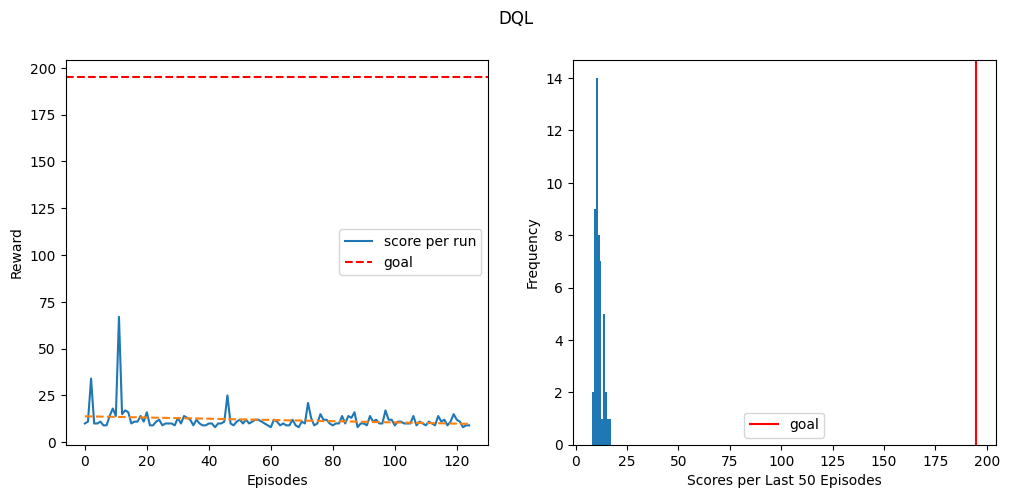

episode: 125, total reward: 9.0


In [ ]:
env = gym.make('CartPole-v1')

# Number of states
n_state = env.observation_space.shape[0]
# Number of actions
n_action = env.action_space.n
# Number of episodes
episodes = 500

# Get DQN results
simple_dqn = DQN(n_state, n_action, hidden_dim=10, lr=0.05)
q_learning(env, simple_dqn, episodes, eps_decay=1, gamma=1)
env.close()

In [10]:

for ep in range(1, 4):
    state = env.reset()
    done = False
    score = 0
    while not done:
        env.render("human")
        q_values = simple_dqn.predict(state)
        action = torch.argmax(q_values).item()
        state, reward, done, info = env.step(action)
        score += reward
    print("Episode {} Score {}".format(ep, score))
env.close()

Episode 1 Score 19.0
Episode 2 Score 22.0
Episode 3 Score 22.0


As we can see, what we implemented above doesnt perform well, for instance, we see our rewards overtime are not verys table. A trick that is interesting for us to explore about DQN is when we start implementing Experience Replay from [this paper](https://arxiv.org/pdf/1312.5602.pdf). In essence, how experience replay works is for us to store the episode at every time step $e_t = (s_t, r_t, a_t, s_{t+1})$ in a pool of memory $D = (e_1, ... e_t)$. We then sample from the memory randomly, and use this to learn off-policy, as with Deep Q-Networks. This makes the problem more like a supervised learning problem which would reduce the unstability

In [11]:
from scripts.dqn.dqn_replay import DQN_replay
from scripts.q_learning import q_learning_with_experience_replay
import gym
import torch

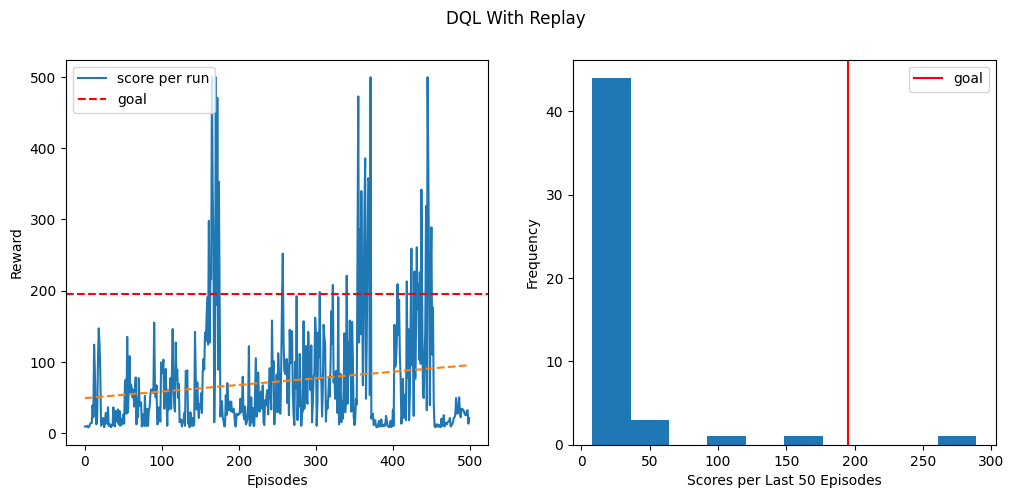

episode: 500, total reward: 21.0
Average replay time: 0.12340460157394409


In [15]:
env = gym.make('CartPole-v1')
# Number of states
n_state = env.observation_space.shape[0]
# Number of actions
n_action = env.action_space.n
# Number of episodes
episodes = 500

replay_size = 50

# Get DQN results
dqn_with_replay = DQN_replay(n_state, n_action)
simple = q_learning_with_experience_replay(env, dqn_with_replay, episodes, replay_size=replay_size, gamma=.9, 
                    epsilon=0.01)
env.close()

In [16]:
for ep in range(1, 4):
    state = env.reset()
    done = False
    score = 0
    while not done:
        env.render("human")
        q_values = dqn_with_replay.predict(state)
        action = torch.argmax(q_values).item()
        state, reward, done, info = env.step(action)
        score += reward
    print("Episode {} Score {}".format(ep, score))
env.close()

Episode 1 Score 33.0
Episode 2 Score 27.0
Episode 3 Score 29.0
